# Machine Learning: AllLife Bank Personal Loan Campaign

## Problem Statement

### Context

AllLife Bank is a US bank that has a growing customer base. The majority of these customers are liability customers (depositors) with varying sizes of deposits. The number of customers who are also borrowers (asset customers) is quite small, and the bank is interested in expanding this base rapidly to bring in more loan business and in the process, earn more through the interest on loans. In particular, the management wants to explore ways of converting its liability customers to personal loan customers (while retaining them as depositors).

A campaign that the bank ran last year for liability customers showed a healthy conversion rate of over 9% success. This has encouraged the retail marketing department to devise campaigns with better target marketing to increase the success ratio.

You as a Data scientist at AllLife bank have to build a model that will help the marketing department to identify the potential customers who have a higher probability of purchasing the loan.

### Objective

To predict whether a liability customer will buy personal loans, to understand which customer attributes are most significant in driving purchases, and identify which segment of customers to target more.

### Data Dictionary
* `ID`: Customer ID
* `Age`: Customer’s age in completed years
* `Experience`: #years of professional experience
* `Income`: Annual income of the customer (in thousand dollars)
* `ZIP Code`: Home Address ZIP code.
* `Family`: the Family size of the customer
* `CCAvg`: Average spending on credit cards per month (in thousand dollars)
* `Education`: Education Level. 1: Undergrad; 2: Graduate;3: Advanced/Professional
* `Mortgage`: Value of house mortgage if any. (in thousand dollars)
* `Personal_Loan`: Did this customer accept the personal loan offered in the last campaign? (0: No, 1: Yes)
* `Securities_Account`: Does the customer have securities account with the bank? (0: No, 1: Yes)
* `CD_Account`: Does the customer have a certificate of deposit (CD) account with the bank? (0: No, 1: Yes)
* `Online`: Do customers use internet banking facilities? (0: No, 1: Yes)
* `CreditCard`: Does the customer use a credit card issued by any other Bank (excluding All life Bank)? (0: No, 1: Yes)

## Importing necessary libraries

In [1]:
# Installing the libraries with the specified version.
#!pip install numpy==1.25.2 pandas==1.5.3 matplotlib==3.7.1 seaborn==0.13.1 scikit-learn==1.2.2 sklearn-pandas==2.2.0 -q --user

**Note**: *After running the above cell, kindly restart the notebook kernel and run all cells sequentially from the start again.*

In [2]:
# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

# Library to split data
from sklearn.model_selection import train_test_split

# To build model for prediction
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree


# To tune different models
from sklearn.model_selection import GridSearchCV

# To get diferent metric scores
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    ConfusionMatrixDisplay,
    make_scorer,
    confusion_matrix
)

# To ignore unnecessary warnings
import warnings
warnings.filterwarnings("ignore")

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler

# to compute distances
from scipy.spatial.distance import cdist

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

%matplotlib inline

In [3]:
# Function that plots charts given column names and sizes
def plotCharts(columns, fig_width, fig_length, grid_row, grid_col, plot_fn, rotate_ticks=False) :
  plt.figure(figsize=(fig_width, fig_length))
  for i, variable in enumerate(columns):
    plt.subplot(grid_row, grid_col, i + 1)
    plot_fn(variable)
    if rotate_ticks:
      plt.xticks(rotation=90)
    plt.tight_layout()
  plt.show()

In [4]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {"Accuracy": acc, "Recall": recall, "Precision": precision, "F1": f1,},
        index=[0],
    )

    return df_perf

In [5]:
# function to plot confusion matrix
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

## Loading the dataset

In [6]:
# loading the dataset
data = pd.read_csv("/content/Loan_Modelling.csv")

In [7]:
df = data.copy()

## Data Overview

* Observations
  - Customers are of age range 23-67 and average age is ~45.
  - 50% are having no Mortgage.
  - 75% are having Online account and CreditCards.
  - 75% doesnt have CD Account, Securities Account and Personal Loan.
  - Target Variable is Personal Loan and we are targetting more than 3 fourth of the total existing customers.
  
* Sanity checks
  - Minimum Experience is -3, it cannot be -ve number, need to fix this.
  - Features like ID, ZIPCode can be ignored as they are not actually proper numeric value that impacts the decision.


In [8]:
df.shape

(5000, 14)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  5000 non-null   int64  
 1   Age                 5000 non-null   int64  
 2   Experience          5000 non-null   int64  
 3   Income              5000 non-null   int64  
 4   ZIPCode             5000 non-null   int64  
 5   Family              5000 non-null   int64  
 6   CCAvg               5000 non-null   float64
 7   Education           5000 non-null   int64  
 8   Mortgage            5000 non-null   int64  
 9   Personal_Loan       5000 non-null   int64  
 10  Securities_Account  5000 non-null   int64  
 11  CD_Account          5000 non-null   int64  
 12  Online              5000 non-null   int64  
 13  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 547.0 KB


In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,5000.0,2500.500000,1443.520003,1.0,1250.75,2500.5,3750.25,5000.0
Age,5000.0,45.338400,11.463166,23.0,35.00,45.0,55.00,67.0
Experience,5000.0,20.104600,11.467954,-3.0,10.00,20.0,30.00,43.0
Income,5000.0,73.774200,46.033729,8.0,39.00,64.0,98.00,224.0
ZIPCode,5000.0,93169.257000,1759.455086,90005.0,91911.00,93437.0,94608.00,96651.0
Family,5000.0,2.396400,1.147663,1.0,1.00,2.0,3.00,4.0
CCAvg,5000.0,1.937938,1.747659,0.0,0.70,1.5,2.50,10.0
Education,5000.0,1.881000,0.839869,1.0,1.00,2.0,3.00,3.0
Mortgage,5000.0,56.498800,101.713802,0.0,0.00,0.0,101.00,635.0
Personal_Loan,5000.0,0.096000,0.294621,0.0,0.00,0.0,0.00,1.0


In [11]:
df.sample(n=10, random_state=1)

,ID,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard
2764,2765,31,5,84,91320,1,2.9,3,105,0,0,0,0,1
4767,4768,35,9,45,90639,3,0.9,1,101,0,1,0,0,0
3814,3815,34,9,35,94304,3,1.3,1,0,0,0,0,0,0
3499,3500,49,23,114,94550,1,0.3,1,286,0,0,0,1,0
2735,2736,36,12,70,92131,3,2.6,2,165,0,0,0,1,0
3922,3923,31,4,20,95616,4,1.5,2,0,0,0,0,1,0
2701,2702,50,26,55,94305,1,1.6,2,0,0,0,0,1,0
1179,1180,36,11,98,90291,3,1.2,3,0,0,1,0,0,1
932,933,51,27,112,94720,3,1.8,2,0,0,1,1,1,1
792,793,41,16,98,93117,1,4.0,3,0,0,0,0,0,1


## Exploratory Data Analysis




**Observations:**

- Age and expericene are strongly correlated on positive side, that makes sense.
- Income and credit card average are also positive correlated.
- Mortgage and income are also slightly positive correlated.
- No strong negative correlation.



 **Questions & Answers:**

 1. What is the distribution of mortgage attribute? Are there any noticeable patterns or outliers in the distribution?
 - Mortgage is right skewed and 50% of users dont have any mortgage cause the outlier pattern.
 2. How many customers have credit cards?
 - ~1500 customers have credit cards and remaining 3500 dont have.
 3. What are the attributes that have a strong correlation with the target attribute (personal loan)?
 - Personal loan has strong positive correlation with Income. Next is with CreditCard Average and then with CD Account.
 4. How does a customer's interest in purchasing a loan vary with their age?
 - 40-50 age group is the highest personal loan customers.
 - Next customer group with highest personal loan is 30-40 age group.
 5. How does a customer's interest in purchasing a loan vary with their education?
 - Advanced/Professional category education customers are the highest personal loan customers.


In [12]:
# Selecting numerical columns
num_col = df.select_dtypes(include=np.number).columns.tolist()
print(len(num_col))
num_col

14


['ID',
 'Age',
 'Experience',
 'Income',
 'ZIPCode',
 'Family',
 'CCAvg',
 'Education',
 'Mortgage',
 'Personal_Loan',
 'Securities_Account',
 'CD_Account',
 'Online',
 'CreditCard']

In [13]:
# Above 14 numeric columns include several categorical and non value numeric fields like ID and ZipCode
# Lets handle categorical features, numerical features and binary features
numeric_features = ['Age', 'Experience', 'Income', 'CCAvg', 'Mortgage']
binary_features = ['Personal_Loan', 'Securities_Account', 'CD_Account', 'Online', 'CreditCard']
categorical_features = ['Family', 'Education']

# Id and ZipCode are not used in the analysis.

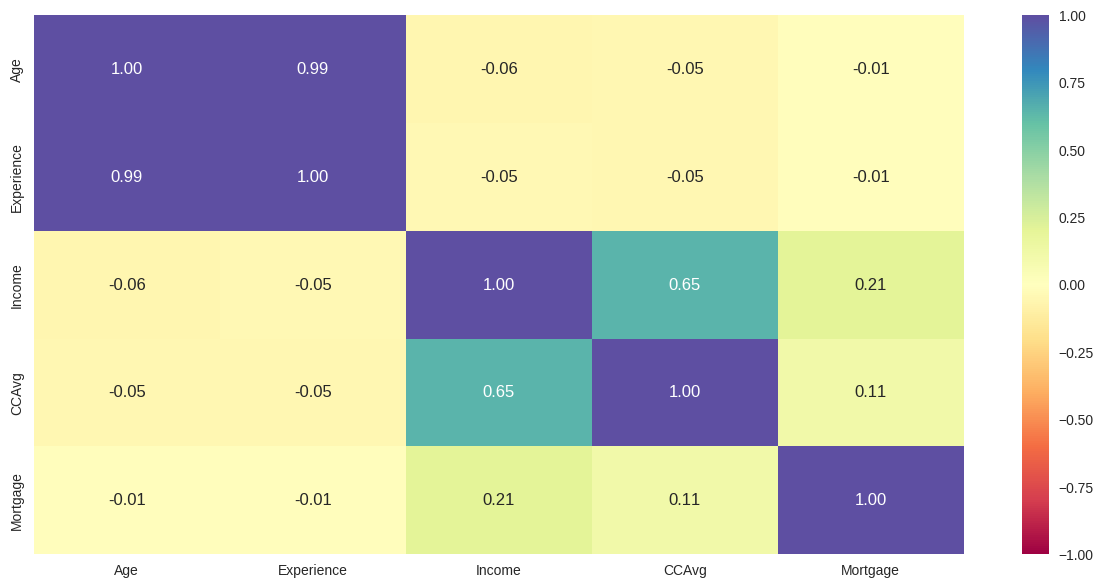

In [14]:
# Use only numerical features for correlation
plt.figure(figsize=(15, 7))
sns.heatmap(df[numeric_features].corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

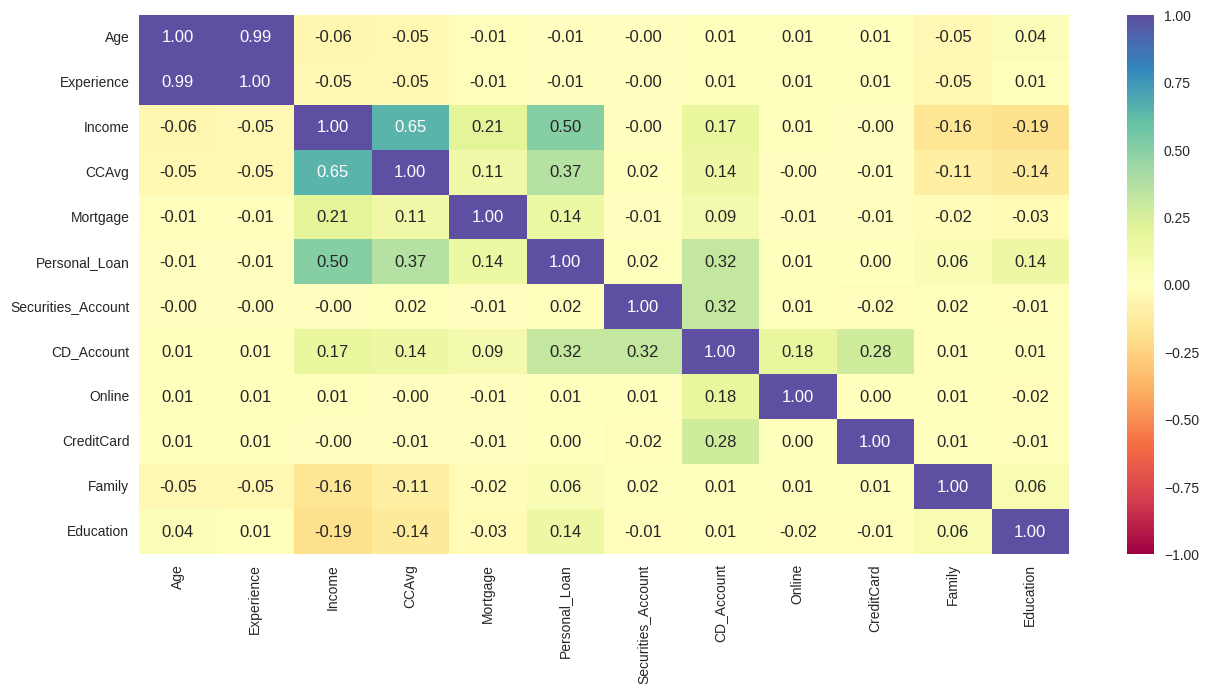

In [15]:
# Use all features for correlation
plt.figure(figsize=(15, 7))
sns.heatmap(df[numeric_features+binary_features+categorical_features].corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

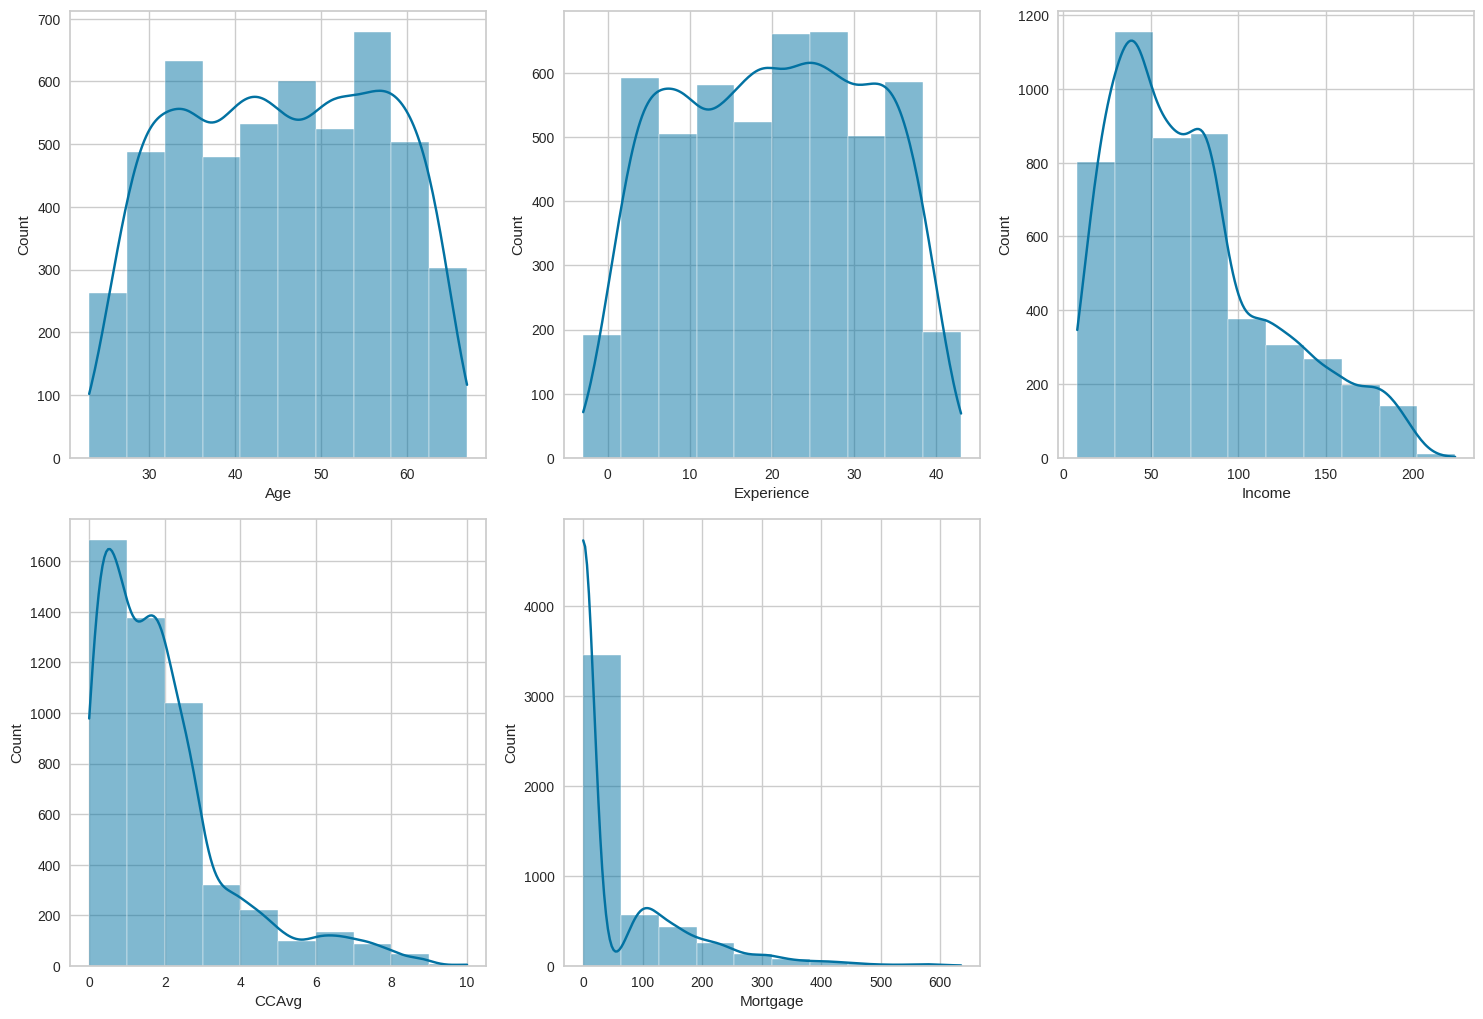

In [16]:
# Plotting histogram with kde on all numeric columns that are meaningful
# This will provide insights on the distribution of the numerical data
plotCharts(numeric_features, 15, 15, 3, 3, lambda variable: sns.histplot(data=df, bins=10, x=variable, kde=True))

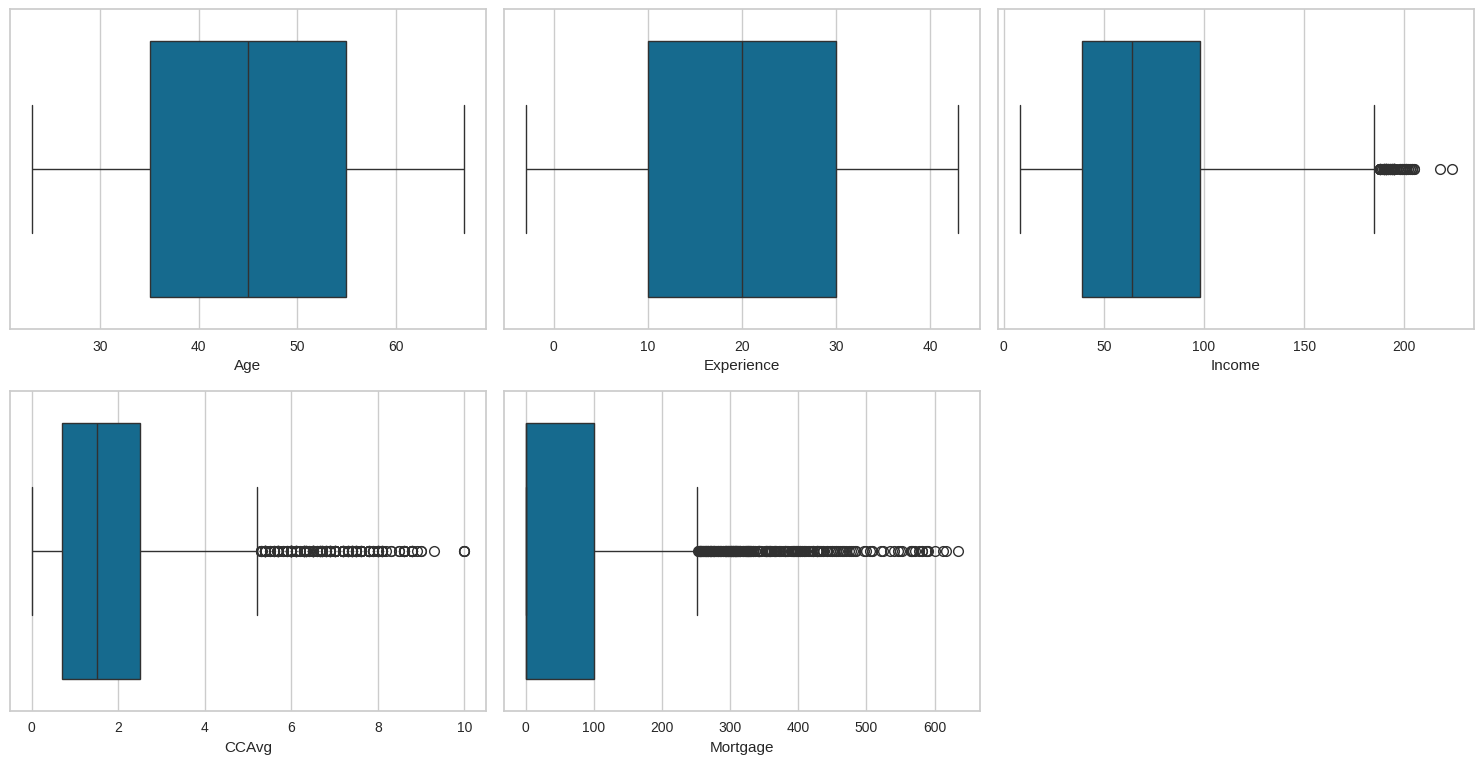

In [17]:
# Plotting boxplot on all numeric columns that are meaningful
# This will provide insights on the distribution, IQR & outliers of the data
plotCharts(numeric_features, 15, 15, 4, 3, lambda variable: sns.boxplot(data=df, x=variable))

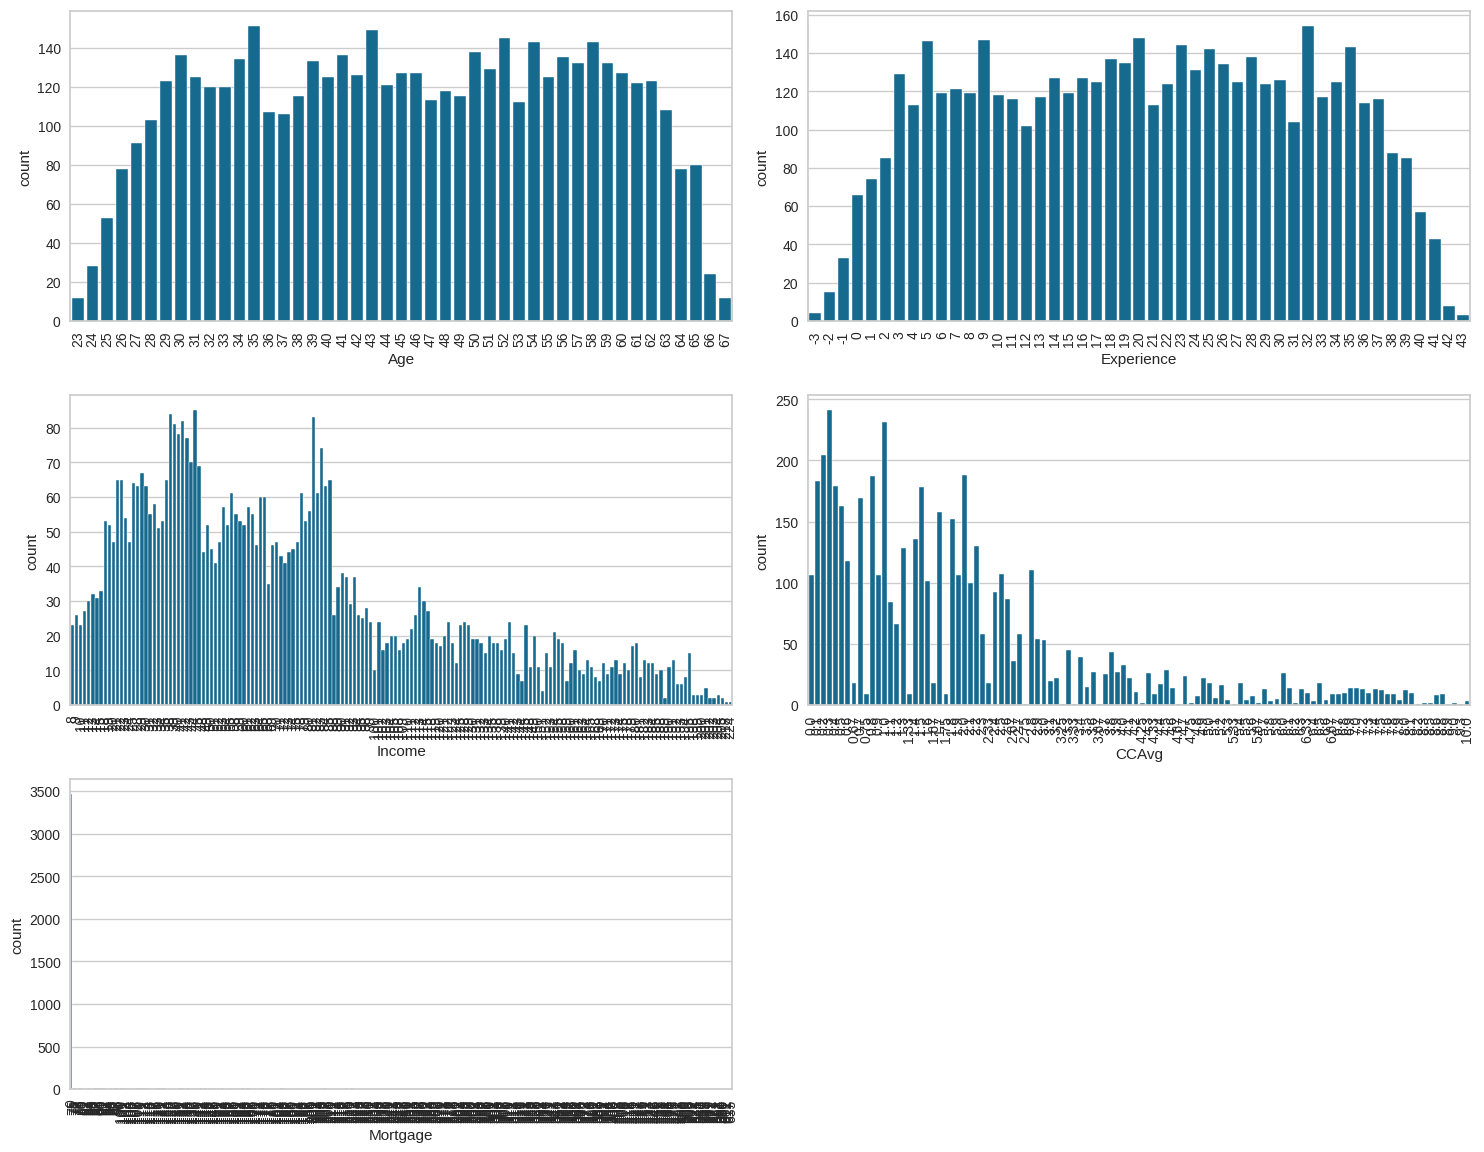

In [18]:
# Plotting countplot on all numeric columns that are meaningful
# This will provide insights on the fequency of the data
plotCharts(numeric_features, 15, 15, 4, 2, lambda variable: sns.countplot(data=df, x=variable), rotate_ticks=True)

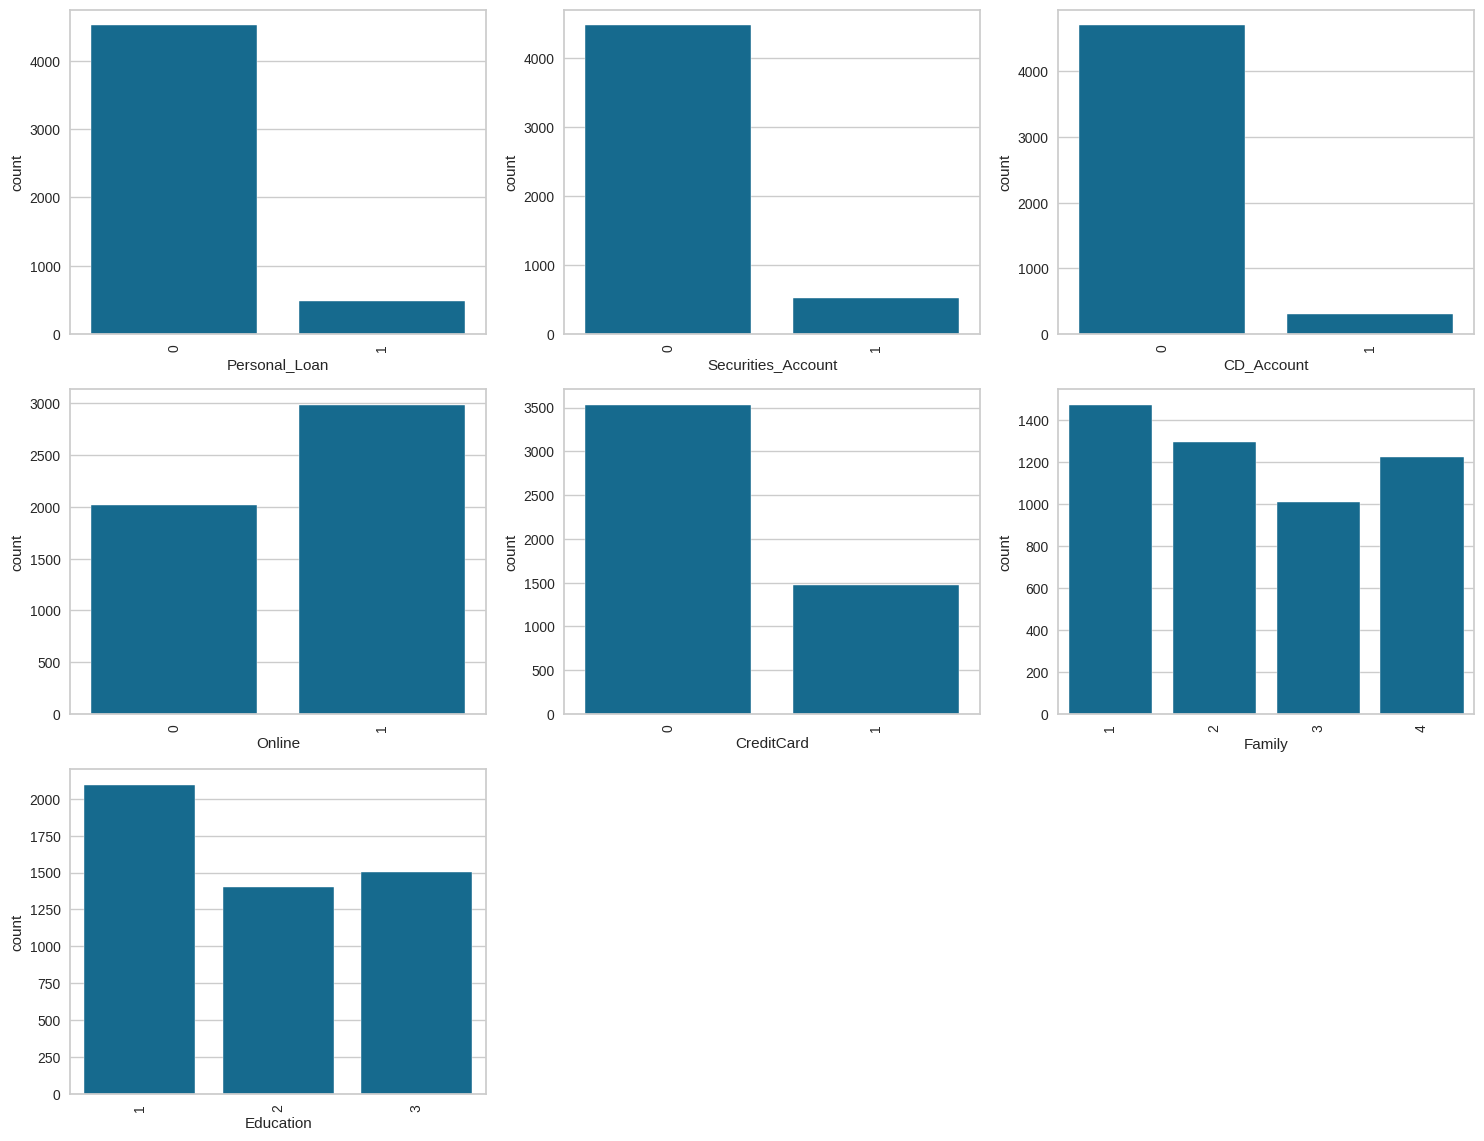

In [19]:
plotCharts(binary_features+categorical_features, 15, 15, 4, 3, lambda variable: sns.countplot(data=df, x=variable), rotate_ticks=True)

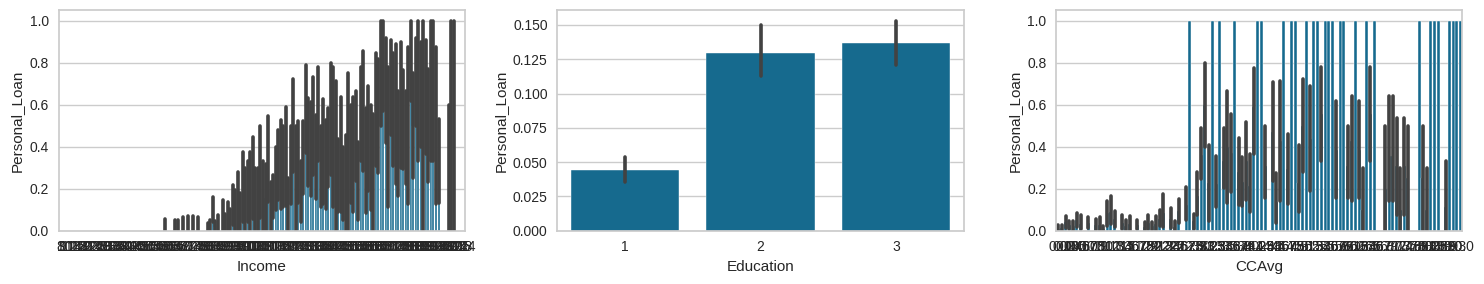

In [20]:
plotCharts(['Income', 'Education', 'CCAvg'], 15, 3, 1, 3, lambda variable: sns.barplot(data=df, x=variable, y='Personal_Loan'))

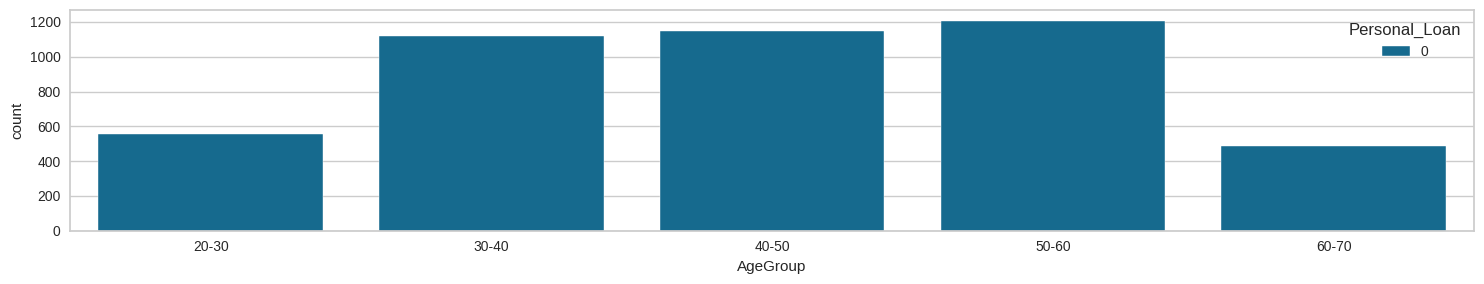

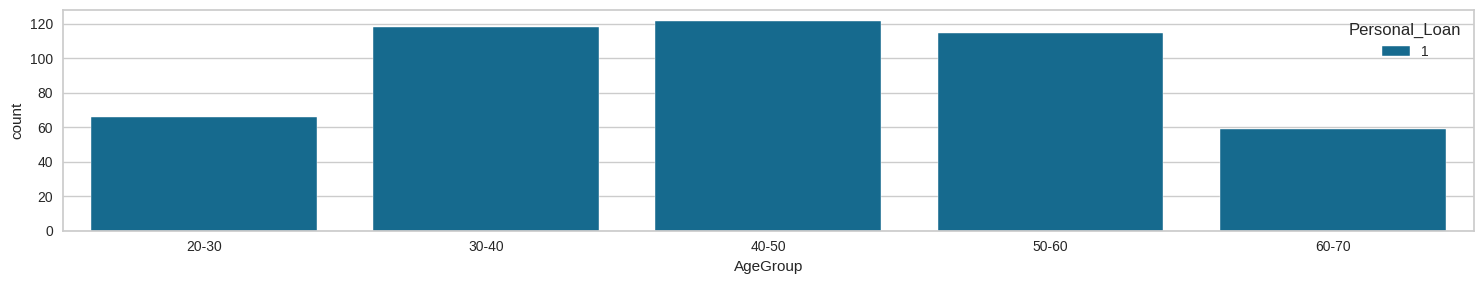

In [21]:
# How does a customer's interest in purchasing a loan vary with their age?
df_age=df.copy()
# Create age bins
df_age['AgeGroup'] = pd.cut(df['Age'], bins=[20, 30, 40, 50, 60, 70], labels=['20-30', '30-40', '40-50', '50-60', '60-70'])
plotCharts(['AgeGroup'], 15, 3, 1, 1, lambda variable: sns.countplot(data=df_age[df_age['Personal_Loan']==0], x=variable, hue='Personal_Loan'))
plotCharts(['AgeGroup'], 15, 3, 1, 1, lambda variable: sns.countplot(data=df_age[df_age['Personal_Loan']==1], x=variable, hue='Personal_Loan'))

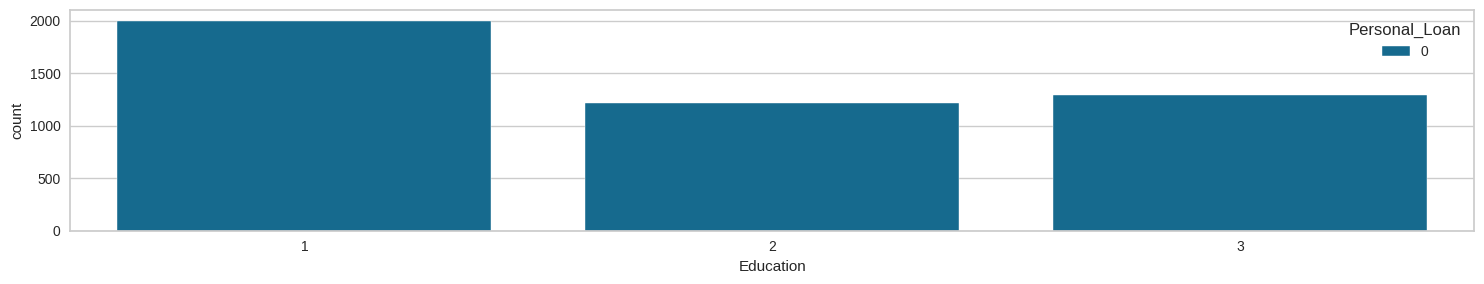

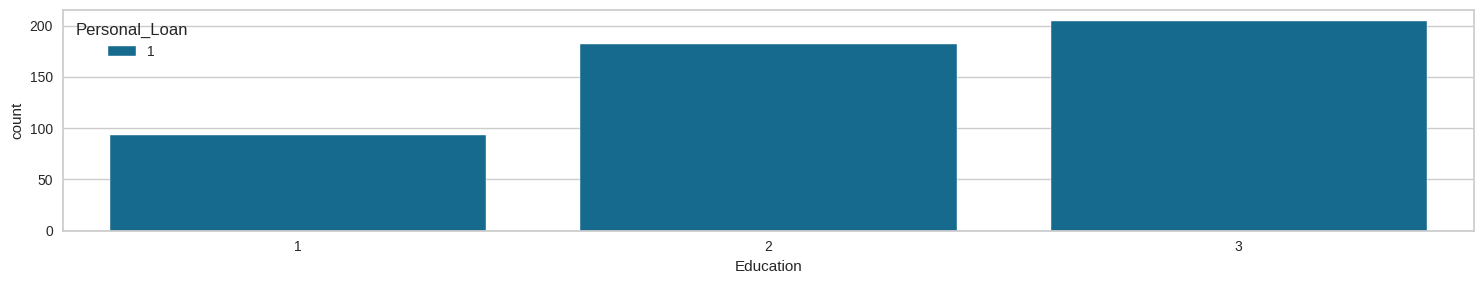

In [22]:
# How does a customer's interest in purchasing a loan vary with their education?
plotCharts(['Education'], 15, 3, 1, 1, lambda variable: sns.countplot(data=df[df['Personal_Loan']==0], x=variable, hue='Personal_Loan'))
plotCharts(['Education'], 15, 3, 1, 1, lambda variable: sns.countplot(data=df[df['Personal_Loan']==1], x=variable, hue='Personal_Loan'))

## Data Preprocessing

* Missing value treatment
* Feature engineering (if needed)
* Outlier detection and treatment (if needed)
* Preparing data for modeling
* Any other preprocessing steps (if needed)

**Observations:**
- No missing or duplicated values.
- Categorical features can be one hot encoded.
- Mortgage is right skewed and 50% of users dont have any mortgage cause the outlier pattern. But all the data are factual, if we treat those then it wont make sense anymore.

**PreProcessing Summary:**
- Removed - Negative experiences are about 1% so removed from the data.
- One hot encoded - categorical features Education & Family.
- Outlier treatment - none


In [23]:
df.duplicated().sum()

0

In [24]:
df.isnull().sum()

ID                    0
Age                   0
Experience            0
Income                0
ZIPCode               0
Family                0
CCAvg                 0
Education             0
Mortgage              0
Personal_Loan         0
Securities_Account    0
CD_Account            0
Online                0
CreditCard            0
dtype: int64

In [25]:
# Remove ID & ZIPCode features

df = df.drop(['ID', 'ZIPCode'] , axis=1)

In [26]:
# Remove negative experience data

df[df['Experience'] < 0].shape
# 52 out of 5000 which is just 1% so lets remove it
df = df[df['Experience'] >= 0]

In [27]:
# One hot encode both categorical data Education & Family

df = pd.get_dummies(df, columns=categorical_features, dtype='int')
df.sample(n=2, random_state=1)

,Age,Experience,Income,CCAvg,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard,Family_1,Family_2,Family_3,Family_4,Education_1,Education_2,Education_3
2376,58,33,23,0.2,0,0,0,0,0,0,0,0,1,0,1,0,0
3641,59,35,74,2.3,0,0,0,0,0,0,0,0,0,1,0,0,1


<Axes: xlabel='CCAvg'>

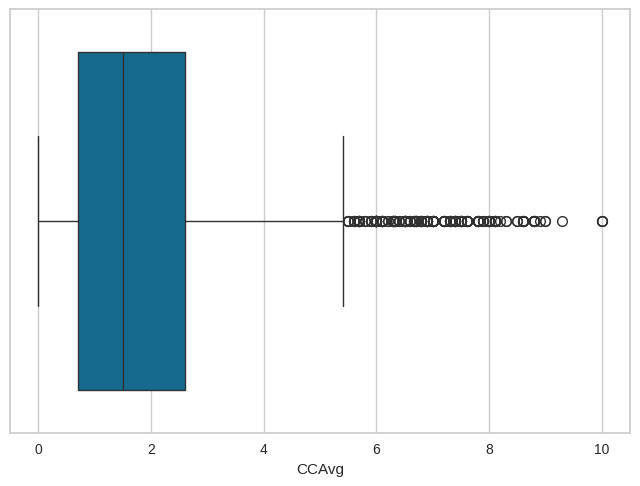

In [28]:
# Check outliers in CCAvg
sns.boxplot(data=df, x='CCAvg')

In [29]:
df['CCAvg'].describe()

count    4948.000000
mean        1.935926
std         1.747694
min         0.000000
25%         0.700000
50%         1.500000
75%         2.600000
max        10.000000
Name: CCAvg, dtype: float64

In [30]:
# Since there are severe outliers on the CCAvg box plot
# lets get lower and upper bound based on IQR to see whether we can treat them
Q1 = df['CCAvg'].quantile(0.25)
Q3 = df['CCAvg'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print(lower_bound)
print(upper_bound)
# seems negative CCAvg for lower bound which doesnt make sense, lets skip the treatment

-2.1500000000000004
5.45


<Axes: xlabel='Mortgage'>

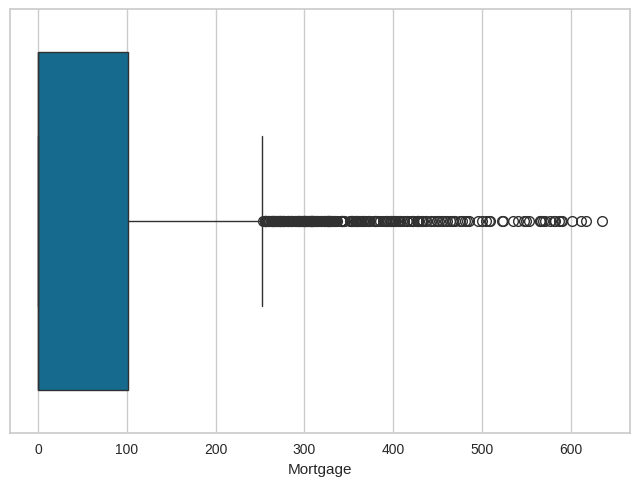

In [31]:
# Check outliers in Mortgage
sns.boxplot(data=df, x='Mortgage')

In [32]:
df['Mortgage'].describe()

count    4948.000000
mean       56.634398
std       101.828885
min         0.000000
25%         0.000000
50%         0.000000
75%       101.000000
max       635.000000
Name: Mortgage, dtype: float64

In [33]:
# Since there are severe outliers on the Morgage box plot
# lets get lower and upper bound based on IQR to see whether we can treat them
Q1 = df['Mortgage'].quantile(0.25)
Q3 = df['Mortgage'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print(lower_bound)
print(upper_bound)
# seems negative mortgage for lower bound which doesnt make sense, lets skip the treatment

-151.5
252.5


## Model Evaluation Criterion

### **Objective 1 - Model 1 - Decision Tree**

To predict whether a liability customer will buy personal loans, to understand which customer attributes are most significant in driving purchases.
  - Decision Tree classifier is suitable for this.

Model 1 - DecisionTree is majorly focused on for prediction objective and evaluated fully for performance, comparision, etc. It helps in understanding the important features that contribute or related to making the Personal_Loan decision.



### **Objective 2 - Model 2 - K Means**

Identify which segment of customers to target more.
  - K Means clustering analysis will help segment customers and hence suitable for this.


Model 2 - KMeans is simply used to do a simple analysis on the customer segments - so no performance improvement done on that. Segmentation help understand the different categories of customers. Using that we can determine whom to target for campaigning on Personal_Loan.

## Objective1 - DecisionTree - Model Building & Prediction

### DecisionTree - Model Building

- For objective1 to predict, 2 different models are built and evaluated for performance & comparision.
  - No class_weight (model_without_class_weight)
    - DecisionTreeClassifier(random_state=1)
  - Balanced class_weight (model_with_class_weight)
    - DecisionTreeClassifier(class_weight='balanced', random_state=1)

In [34]:
# After preprocessing how the data looks like
df.sample(n=2, random_state=1)

,Age,Experience,Income,CCAvg,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard,Family_1,Family_2,Family_3,Family_4,Education_1,Education_2,Education_3
2376,58,33,23,0.2,0,0,0,0,0,0,0,0,1,0,1,0,0
3641,59,35,74,2.3,0,0,0,0,0,0,0,0,0,1,0,0,1


In [35]:
# Drop the unwanted features and target variable from X
# Use only the target variable in Y

SEED=1
X = df.drop(['Personal_Loan'], axis=1)
Y = df["Personal_Loan"]

# Splitting data in train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.25, random_state=SEED
)
X.sample(n=2, random_state=1)

,Age,Experience,Income,CCAvg,Mortgage,Securities_Account,CD_Account,Online,CreditCard,Family_1,Family_2,Family_3,Family_4,Education_1,Education_2,Education_3
2376,58,33,23,0.2,0,0,0,0,0,0,0,1,0,1,0,0
3641,59,35,74,2.3,0,0,0,0,0,0,0,0,1,0,0,1


In [36]:
print("Shape of Training set : ", X_train.shape)
print("Shape of test set : ", X_test.shape)
print("Percentage of classes in training set:")
print(y_train.value_counts(normalize=True))
print("Percentage of classes in test set:")
print(y_test.value_counts(normalize=True))

Shape of Training set :  (3711, 16)
Shape of test set :  (1237, 16)
Percentage of classes in training set:
Personal_Loan
0    0.902991
1    0.097009
Name: proportion, dtype: float64
Percentage of classes in test set:
Personal_Loan
0    0.902991
1    0.097009
Name: proportion, dtype: float64


In [37]:
# Build model_without_class_weight with No class_weight
model_without_class_weight = DecisionTreeClassifier(random_state=1)
model_without_class_weight.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

In [38]:
# Explore the performance of the model_without_class_weight on train dataset
decision_tree_perf_train_without = model_performance_classification_sklearn(
    model_without_class_weight, X_train, y_train
)
decision_tree_perf_train_without

,Accuracy,Recall,Precision,F1
0,1.0,1.0,1.0,1.0


In [39]:
# Explore the performance of the model_without_class_weight on test dataset
decision_tree_perf_test_without = model_performance_classification_sklearn(
    model_without_class_weight, X_test, y_test
)
decision_tree_perf_test_without

,Accuracy,Recall,Precision,F1
0,0.982215,0.875,0.9375,0.905172


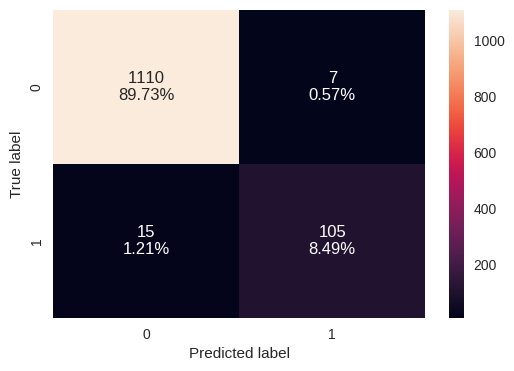

In [40]:
# Build confusion matrix on model_without_class_weight with test data
confusion_matrix_sklearn(model_without_class_weight, X_test, y_test)

**Observation on model_without_class_weight**

- Having good recall and precision scores, model having balanced performance.
- Confusion matrix confirms the same with high True Negatives and True Positives.


In [41]:
# Build model with "balanced" class_weight
model_with_class_weight = DecisionTreeClassifier(random_state=1, class_weight="balanced")
model_with_class_weight.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', random_state=1)

In [42]:
# Explore the performance of the model on train dataset
decision_tree_perf_train = model_performance_classification_sklearn(
    model_with_class_weight, X_train, y_train
)
decision_tree_perf_train

,Accuracy,Recall,Precision,F1
0,1.0,1.0,1.0,1.0


In [43]:
# Explore the performance of the model on test dataset
decision_tree_with_class_weight_perf_test = model_performance_classification_sklearn(
    model_with_class_weight, X_test, y_test
)
decision_tree_with_class_weight_perf_test

,Accuracy,Recall,Precision,F1
0,0.983832,0.891667,0.938596,0.91453


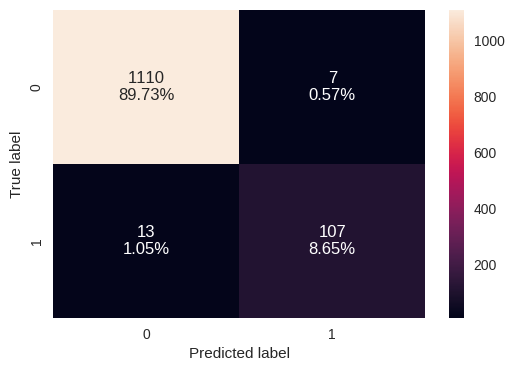

In [44]:
# Build confusion matrix on model with test data
confusion_matrix_sklearn(model_with_class_weight, X_test, y_test)

**Observation on model with "balanced" class_weight**

- This model is having better accuracy and precision than model0 without class_weight.
- Even having slightly better F1 score, but little less Recall score.
- Overall this seems to be a better model so far.


### DecisionTree - Model Performance Improvement

**PrePruning DecisionTree**

- Performance evaluation is done with parameter tuning to find the optimal max_depth and samples split, etc.
- Below model is selected based on the tuning
        DecisionTreeClassifier(class_weight='balanced', max_depth=2,
              min_samples_split=10, random_state=1)

- But comparision on the fine tuned model and base model is done.
- Results are in a next section.


In [45]:
# Choose the type of classifier.
estimator = DecisionTreeClassifier(random_state=1)

# Grid of parameters to choose from
parameters = {
    "class_weight": [None, "balanced"],
    "max_depth": np.arange(1, 9, 1),
    "min_samples_split": [5, 10, 30, 50, 70]#,
}

# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(recall_score)

# Run the grid search
grid_obj = GridSearchCV(estimator, parameters, scoring=acc_scorer, cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
estimator = grid_obj.best_estimator_

# Fit the best algorithm to the data.
estimator.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=2,
                       min_samples_split=5, random_state=1)

In [46]:
# Explore the performance of the tuned model on train dataset
decision_tree_tune_perf_train = model_performance_classification_sklearn(
    estimator, X_train, y_train
)
decision_tree_tune_perf_train

,Accuracy,Recall,Precision,F1
0,0.790622,1.0,0.316623,0.480962


In [47]:
# Explore the performance of the tuned model on test dataset
decision_tree_tune_perf_test = model_performance_classification_sklearn(
    estimator, X_test, y_test
)
decision_tree_tune_perf_test

,Accuracy,Recall,Precision,F1
0,0.80194,1.0,0.328767,0.494845


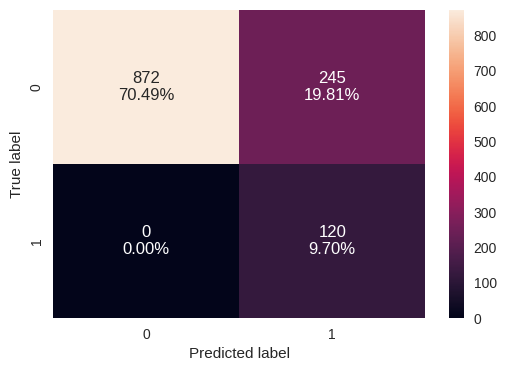

In [48]:
# Build confusion matrix on model0 with test data
confusion_matrix_sklearn(estimator, X_test, y_test)

### Model Comparison and Final Model Selection

In [49]:
# training performance comparison

models_train_comp_df = pd.concat(
    [
        decision_tree_perf_train_without.T,
        decision_tree_perf_train.T,
        decision_tree_tune_perf_train.T
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "Decision Tree without class_weight",
    "Decision Tree with class_weight",
    "Decision Tree (Pre-Pruning)"
]
print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,Decision Tree without class_weight,Decision Tree with class_weight,Decision Tree (Pre-Pruning)
Accuracy,1.0,1.0,0.790622
Recall,1.0,1.0,1.000000
Precision,1.0,1.0,0.316623
F1,1.0,1.0,0.480962


In [50]:
# testing performance comparison

models_test_comp_df = pd.concat(
    [
        decision_tree_perf_test_without.T,
        decision_tree_with_class_weight_perf_test.T,
        decision_tree_tune_perf_test.T
    ],
    axis=1,
)
models_test_comp_df.columns = [
    "Decision Tree without class_weight",
    "Decision Tree with class_weight",
    "Decision Tree (Pre-Pruning)"
]
print("Test set performance comparison:")
models_test_comp_df

Test set performance comparison:


,Decision Tree without class_weight,Decision Tree with class_weight,Decision Tree (Pre-Pruning)
Accuracy,0.982215,0.983832,0.801940
Recall,0.875000,0.891667,1.000000
Precision,0.937500,0.938596,0.328767
F1,0.905172,0.914530,0.494845


#### **Comparision Results and Final Model Selection**
- Below are observed on the test set performance comparision results
  - Decistion Tree model with class_weight has higher performance than the pre-pruning model and the default model with no class_weight.
  - Higher performance is implied by comparitively good score on Accuracy,  Recall as well as Precision.
  - PrePruned model has very high recall which is good but it also signals overfitting. And the Precision is very low so this model cannot be considered.

- Final Model selected
  - Decision Tree with "balanced" class_weight (model_with_class_weight)

In [51]:
# Select features from final selected model
# final_model = model_without_class_weight
final_model = model_with_class_weight   # weight balanced
# final_model = estimator  # model finalized using GridSearchCV

feature_names = list(X_train.columns)
importances = final_model.feature_importances_
indices = np.argsort(importances)

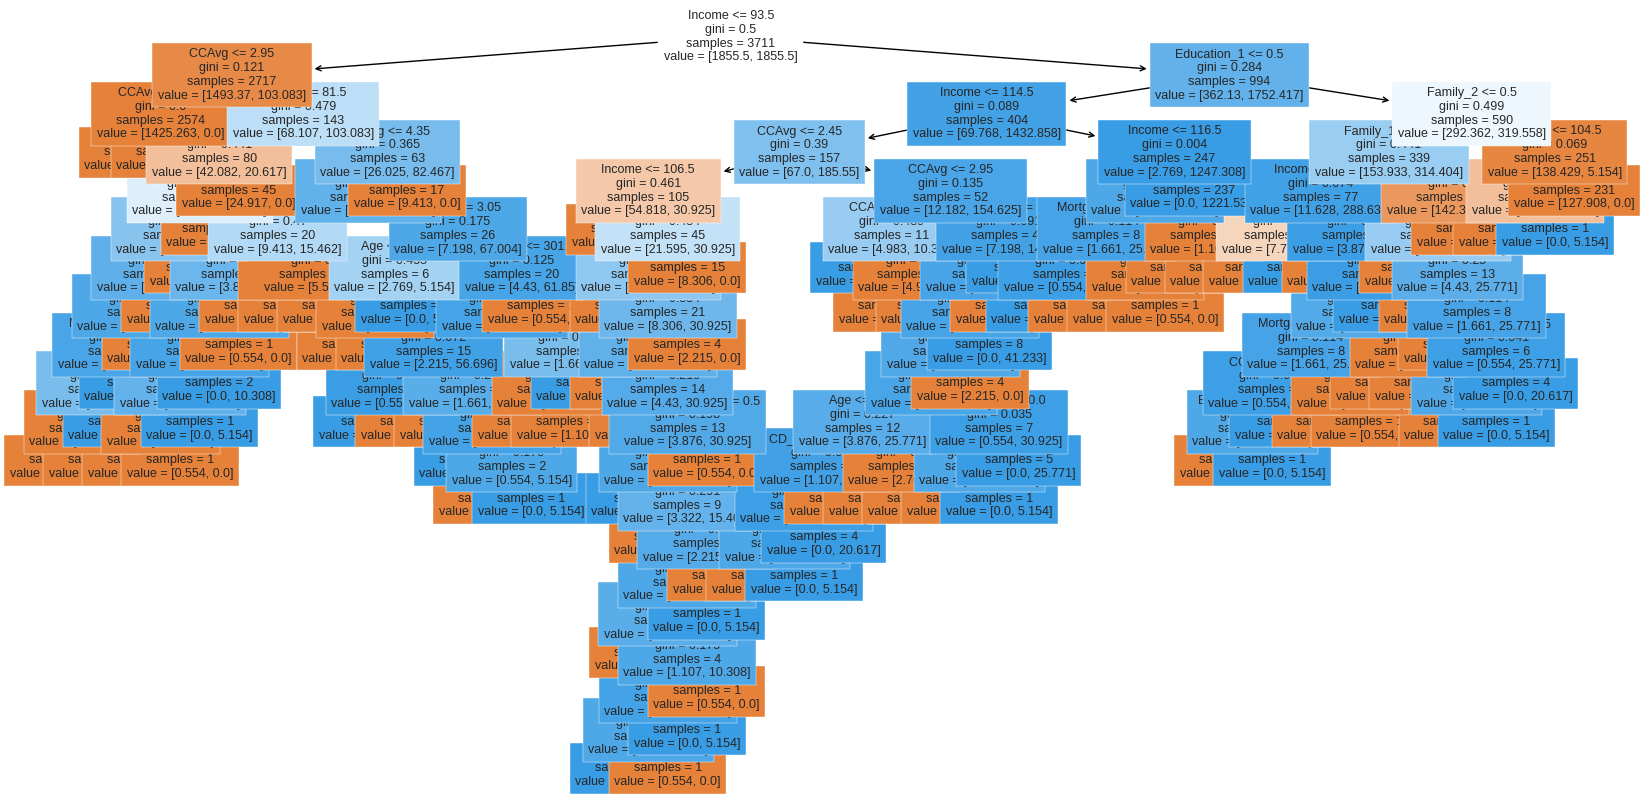

In [52]:
# Plot the deicsion tree diagram
plt.figure(figsize=(20, 10))
out = tree.plot_tree(
    final_model,
    feature_names=feature_names,
    filled=True,
    fontsize=9,
    node_ids=False,
    class_names=None,
)
# below code will add arrows to the decision tree split if they are missing
for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor("black")
        arrow.set_linewidth(1)
plt.show()

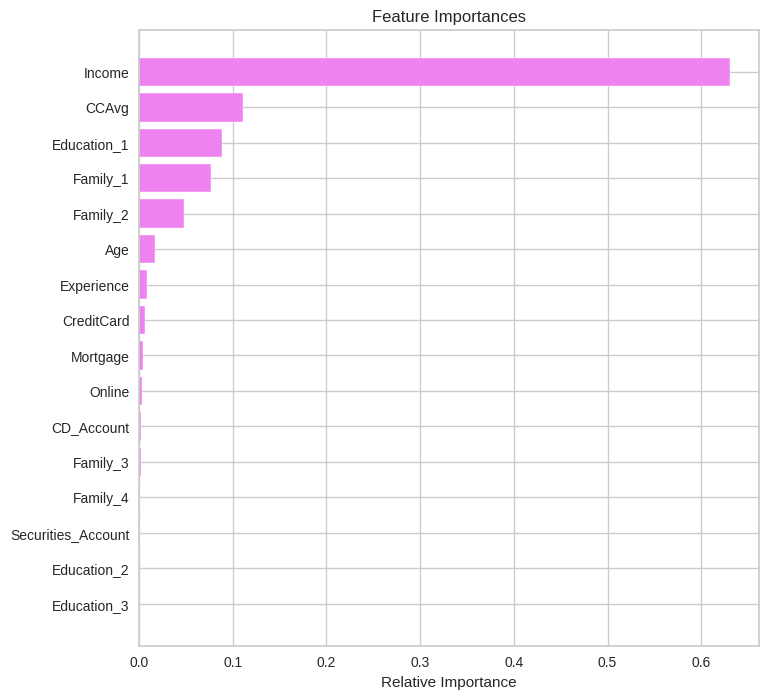

In [53]:
# Plot important of features in the tree building
importances = final_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(8, 8))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

### Summary

- **Income** is the most important feature in determining the target variable which is customer taking Personal Loans
- Next closest feature thats related to target variable is based on customers **CreditCard Average**
- And the next one is customers having **CD Account**

## Objective2 - KMeans - Model Building & Data Segmentation

- For objective2 to classify, KMeans classifier is used
  - Standard Scaler
    - Scaling is done on the numeric_features.
  - OneHot Encoder
    - One hot encoding is already done the df instance for categorical_features.
  - Elbow chart
    - k is better at 3 based on the chart.
  - Fit & Predict
    - With final dataframe which is derived from concatenating scaled and onehot encoded dataframe, using k as 3, k means clustering model is created.
  - Plot segments
    - Segments and clusters are plotted with different colors to differentiate.
  

In [54]:
# Lets sample and see the one hot encoded data
df.sample(n=2, random_state=10)

,Age,Experience,Income,CCAvg,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard,Family_1,Family_2,Family_3,Family_4,Education_1,Education_2,Education_3
1851,34,8,60,2.2,0,0,0,0,0,1,0,0,0,1,0,1,0
4914,65,39,94,2.0,0,0,0,0,0,1,1,0,0,0,1,0,0


In [55]:
# Scaling the dataset before clustering
# Create a dataframe of the scaled columns
print(numeric_features)
scaler = StandardScaler()
numeric_features_df = df[numeric_features].copy()
numeric_features_scaled = scaler.fit_transform(numeric_features_df)
numeric_features_scaled_df = pd.DataFrame(numeric_features_scaled, columns=numeric_features_df.columns)
numeric_features_scaled_df.head()

# Combine both onehot encoded df and scaled df
final_df = numeric_features_scaled_df
final_df.sample(n=2, random_state=10)

['Age', 'Experience', 'Income', 'CCAvg', 'Mortgage']


,Age,Experience,Income,CCAvg,Mortgage
1832,-1.020990,-1.090198,-0.299612,0.151114,-0.556228
4863,1.717624,1.650538,0.437789,0.036666,-0.556228


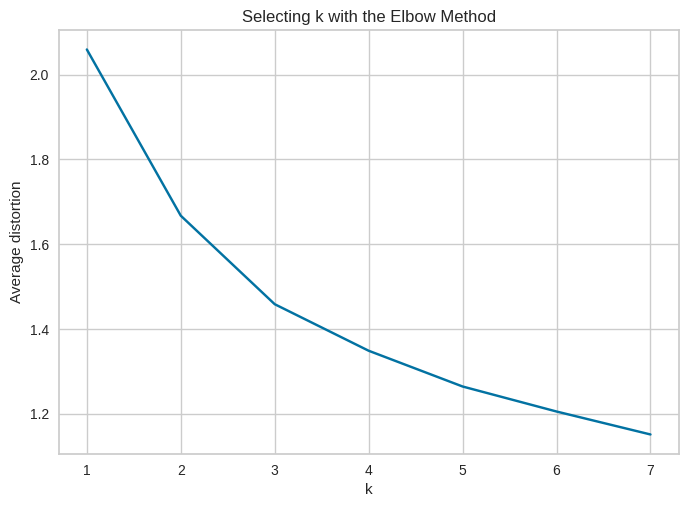

In [56]:
# Build multiple kmeans clustering with different cluster numbers ranging from 1 to 6
clusters = range(1, 8)
meanDistortions = []

for k in clusters:
    model = KMeans(n_clusters=k)
    model.fit(final_df)
    prediction = model.predict(final_df)
    distortion = (
        sum(
            np.min(cdist(final_df, model.cluster_centers_, "euclidean"), axis=1)
        )
        / final_df.shape[0]
    )
    meanDistortions.append(distortion)

# Plot the elbow diagram to find best k
plt.plot(clusters, meanDistortions, "bx-")
plt.xlabel("k")
plt.ylabel("Average distortion")
plt.title("Selecting k with the Elbow Method")
plt.show()

<Figure size 1000x1000 with 0 Axes>

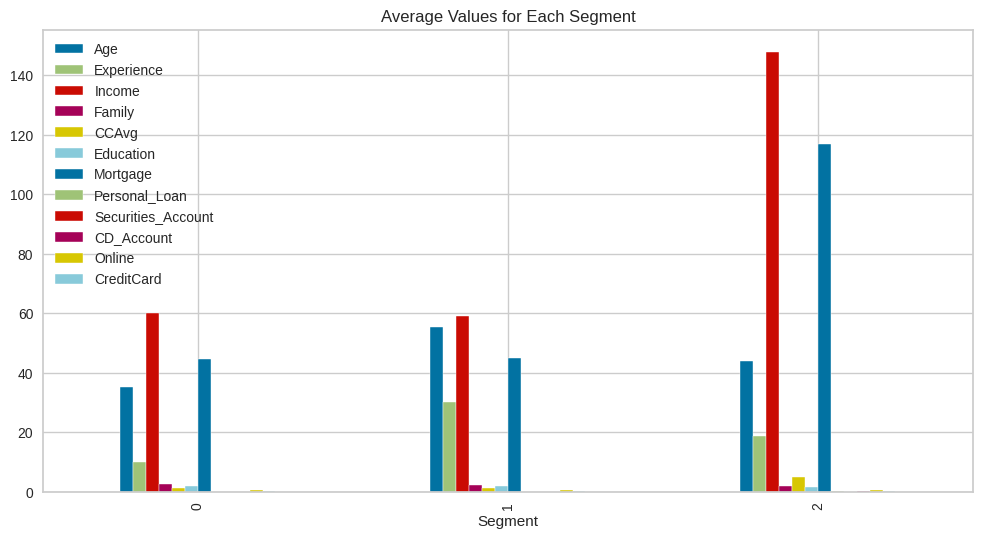

In [57]:
# k seems better at 3 as significant change in elbow at that point
kmeans = KMeans(n_clusters=3, random_state=12)
segments = kmeans.fit_predict(final_df)

# Add segments to the original dataframe
df_og = pd.DataFrame(data).drop(['ID', 'ZIPCode'] , axis=1)
df_og = df_og[df_og['Experience'] >= 0]
df_og['Segment'] = segments

# Plot distribution of data against segment
plt.figure(figsize=(10, 10))
df_og.groupby('Segment').mean().plot(kind='bar', figsize=(12, 6))
plt.title('Average Values for Each Segment')
plt.show()

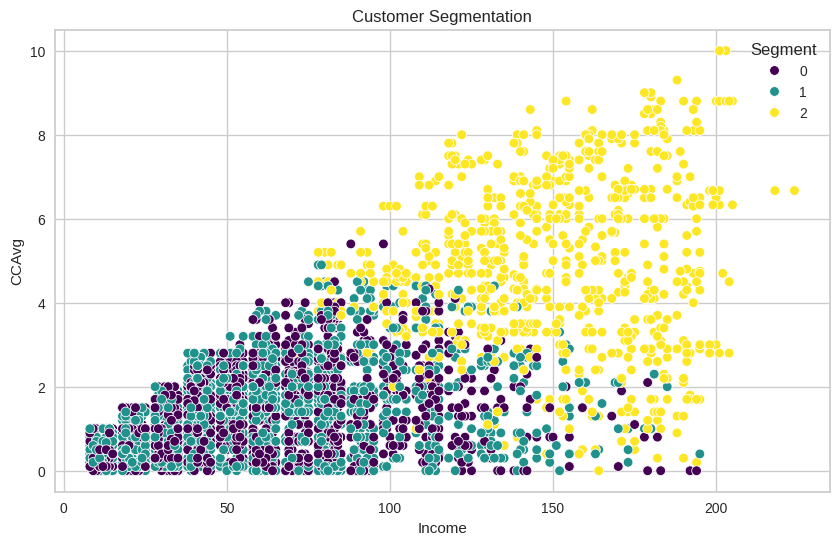

In [58]:
# Plot segments in scatterplot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Income', y='CCAvg', hue='Segment', data=df_og, palette='viridis')
plt.title('Customer Segmentation')
plt.show()

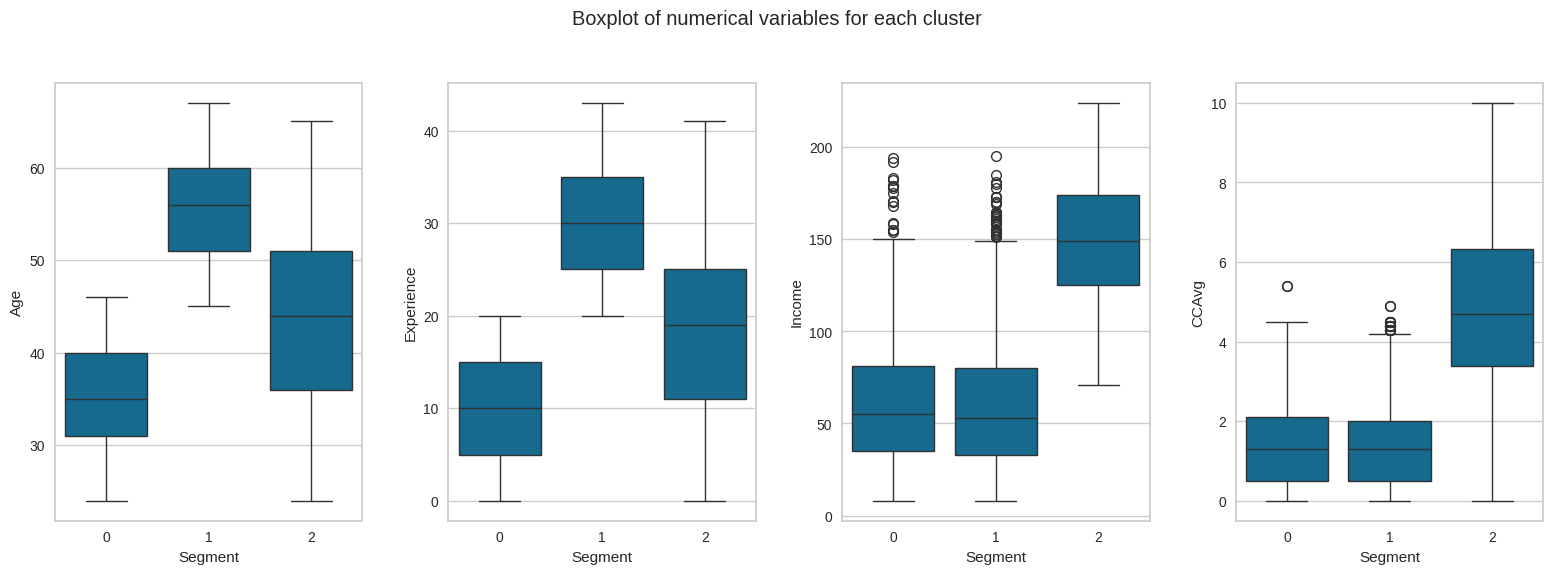

In [59]:
# Plot boxplots of segment against most important numerical features to find the distribution
fig, axes = plt.subplots(1, 4, figsize=(16, 6))
fig.suptitle("Boxplot of numerical variables for each cluster")
counter = 0
for ii in range(4):
    sns.boxplot(ax=axes[ii], y=df_og[numeric_features[counter]], x=df_og["Segment"])
    counter = counter + 1
fig.tight_layout(pad=2.0)

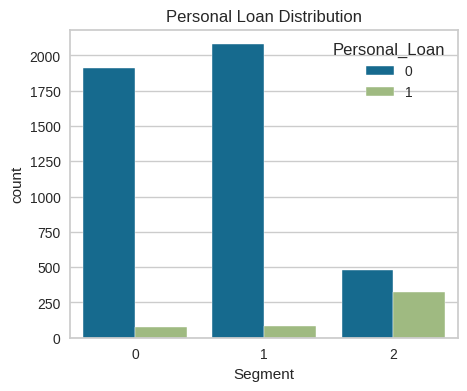

In [60]:
# Plot boxplots of segment against target variable to find which segment is more aligned
fig, axes = plt.subplots(1, 1, figsize=(5, 4))
sns.countplot(hue=df_og['Personal_Loan'], x=df_og["Segment"])
plt.title('Personal Loan Distribution')
plt.show()

### Observations

#### Segment 0
- Lowest Age
- Lowest Experience
- Lower Income
- Lower CCAvg

- Lowest Average Age
- Lowest Average Experience
- Moderate Average Income
- Moderate Average Mortgage


#### Segment 1
- Highest Age
- Highest Experience
- Lower Income
- Lower CCAvg

- Highest Average Age
- Highest Average Experience
- Lowest Average Income
- Moderate Average Mortgage


#### Segment 2
- Average Age
- Average Experience
- Highest Income
- Highest CCAvg

- Moderate Average Age
- Moderate Average Experience
- Highest Average Income
- Highest Average Mortgage

### Summary

- 3 segments of customers are best identified.
- 2 most important features **Income** and **Credit Card Average** are mostly helping categorizing those segments.
- Segment 2 is the one that has more customer having Personal Loan.

- Customer classification
  - Segment 0 - Younger and lower income

  - Segment 1 - High experience and lower income

  - Segment 2 - High income and spending





## Actionable Insights and Business Recommendations


### Recap of Objectives & Results

Objective 1 - To predict whether a liability customer will buy personal loans, to understand which customer attributes are most significant in driving purchases.
- Most Important Features
  - Income
  - CCAvg
  

Objective 2  - Identify which segment of customers to target more.
- Segment to target more
  - Segment 2


### Actionable Insights

- Segment 0 - Younger and lower income
  - is in early stage of career and has significant lower financial obligations, they can spend but given less premium/interest in spending.

- Segment 1 - High experience and lower income
  - is just opposie to segment 0, in their late stage of career and has lowest average income. Their growth is stagnant and wont be doing lot of spending.

- Segment 2 - High income and good spending
  - is just the right customers who can be targetted for personal loan with higher credit limits. As they have more growth room and with high income they would be willing to spend more.


### Business Recommendations

Following are recommended to the bank based on customer classificaiton and also few general recommendations.

#### Based on customer classification


- Segment 0
  - Targetted campaign for personalized loans with lower interest rates.
  - Since they are young and lower experience, bank can provide education insights and money management tool to see/manage their spending with lower monthly subscription plan.
  - Savings account and CD accounts can be recommended or marketted.

- Segment 1
  - Targetted campaign for retirement account and pension plan recommendations.
  - Since they are experienced and towards retirement, bank can provide subscription plans on retirement education.
  - Bank can recommend products that can give retiement income or monthly income for higher deposits.

- Segment 2
  - Targetted campaign for personal loans with higher credit limits.
  - Encourage their spending by providing loyalty stages and discounts based on the loyalty levels, like silver, gold, platinum, etc.
  - New products can be marketted first for this segment as they have higher spending average and also higher income which will trigger their usage.


  #### General Ideas

  - Above segmentation gives an idea to create products that are unique and to be targetted for each segment. For instance, we can create a pension plan with monthly returns for retirees or a new High yield savings account for young savers, etc.

  - Also digital product utilization seems to be very low, so focus on improving online presence by providing incentives for using mobile apps, educate first 2 segments about the online advantages.

  - Integrate latest digital technologies like the model we built for predicting the posibility of a customer taking a personal loan into existing marketting products, so that more customer leads can happen.

___